In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import ghalton
import numpy as np
import cv2
import scipy.ndimage

import sys
import theano
import theano.tensor as T
rng = np.random.RandomState(42)
theano.config.floatX = 'float32'

In [2]:
'''
Helper function that cleans up list_directory
removes hidden files
'''
def clean(lis):
    try:
        
        lis.remove('.DS_Store')
    except:
        lis = lis
    return lis

'''
Helper function that retrieves all data files
cleans up the directory to leave only .dat files
'''
def get_files(lis):
    try:
        for i in list(lis):
            if('.dat' not in i):
                lis.remove(i)
    except:
        lis = lis
    return lis

In [96]:
path1 = '/Users/zyzdiana/Dropbox/vNav_Test_Data/'
files1 = get_files(os.listdir(path1))
pos1 = files1[:(len(files1)/2)]
pos2 = files1[(len(files1)/2):]
print pos1
print pos2

['Pos_1_View_1_Rep_1.dat', 'Pos_1_View_1_Rep_2.dat', 'Pos_1_View_1_Rep_3.dat', 'Pos_1_View_1_Rep_4.dat', 'Pos_1_View_1_Rep_5.dat', 'Pos_1_View_2_Rep_1.dat', 'Pos_1_View_2_Rep_2.dat', 'Pos_1_View_2_Rep_3.dat', 'Pos_1_View_2_Rep_4.dat', 'Pos_1_View_2_Rep_5.dat', 'Pos_1_View_3_Rep_1.dat', 'Pos_1_View_3_Rep_2.dat', 'Pos_1_View_3_Rep_3.dat', 'Pos_1_View_3_Rep_4.dat', 'Pos_1_View_3_Rep_5.dat']
['Pos_2_View_1_Rep_1.dat', 'Pos_2_View_1_Rep_2.dat', 'Pos_2_View_1_Rep_3.dat', 'Pos_2_View_1_Rep_4.dat', 'Pos_2_View_1_Rep_5.dat', 'Pos_2_View_2_Rep_1.dat', 'Pos_2_View_2_Rep_2.dat', 'Pos_2_View_2_Rep_3.dat', 'Pos_2_View_2_Rep_4.dat', 'Pos_2_View_2_Rep_5.dat', 'Pos_2_View_3_Rep_1.dat', 'Pos_2_View_3_Rep_2.dat', 'Pos_2_View_3_Rep_3.dat', 'Pos_2_View_3_Rep_4.dat', 'Pos_2_View_3_Rep_5.dat']


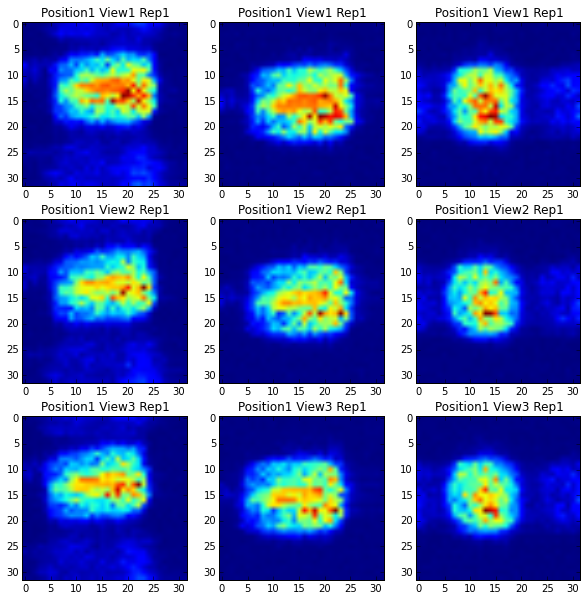

In [97]:
vol1 = np.memmap(path1+pos1[0], dtype=np.float32, shape=(32,32,32))
vol1 = np.array(vol1)
vol2 = np.memmap(path1+pos1[5], dtype=np.float32, shape=(32,32,32))
vol2 = np.array(vol2)
vol3 = np.memmap(path1+pos1[10], dtype=np.float32, shape=(32,32,32))
vol3 = np.array(vol3)
fig, ax = plt.subplots(3,3)
fig.set_figwidth(10)
fig.set_figheight(10)
[ax[0][i].imshow(vol1.max(axis=i), cmap='jet') for i in xrange(3)]
[ax[0][i].set_title('Position1 View1 Rep1') for i in xrange(3)]
[ax[1][i].imshow(vol2.max(axis=i),cmap='jet') for i in xrange(3)]
[ax[1][i].set_title('Position1 View2 Rep1') for i in xrange(3)]
[ax[2][i].imshow(vol3.max(axis=i),cmap='jet') for i in xrange(3)]
[ax[2][i].set_title('Position1 View3 Rep1') for i in xrange(3)]
plt.show()
plt.close(fig)

In [32]:
def trilinear_interp(volume, x, y, z):
    
    # find the closest grid of the target points
    x0 = T.floor(x).astype('int32')
    x1 = x0 + 1
    y0 = T.floor(y).astype('int32')
    y1 = y0 + 1
    z0 = T.floor(z).astype('int32')
    z1 = z0 + 1
    
    # define some coefficients
    xd = x-x0
    yd = y-y0
    zd = z-z0
    
    # Clip
    x0 = (x0 + volume.shape[0]) % volume.shape[0]
    x1 = (x1 + volume.shape[0]) % volume.shape[0]
    y0 = (y0 + volume.shape[0]) % volume.shape[0]
    y1 = (y1 + volume.shape[0]) % volume.shape[0]
    z0 = (z0 + volume.shape[0]) % volume.shape[0]
    z1 = (z1 + volume.shape[0]) % volume.shape[0] 

    
    # set up for the bilinear interpolation
    C00 = volume[y0,x0,z0]*(1-xd) + volume[y0,x1,z0]*xd
    C10 = volume[y1,x0,z0]*(1-xd) + volume[y1,x1,z0]*xd
    
    C01 = volume[y0,x0,z1]*(1-xd) + volume[y0,x1,z1]*xd
    C11 = volume[y1,x0,z1]*(1-xd) + volume[y1,x1,z1]*xd
    
    C0 = C00*(1-yd) + C10*yd
    C1 = C01*(1-yd) + C11*yd
    
    C = C0*(1-zd) + C1*zd
    return C

def translation(volume, t):
    return scipy.ndimage.interpolation.shift(volume, t, order=1, mode='wrap')

In [129]:
def to_radian(theta):
    '''
    Convert theta from degrees to radians
    '''
    return theta*np.pi/180.

def rotation_matrix_zyx(gamma, beta, alpha):
    """
    Return the rotation matrix associated with counterclockwise rotation 
    about x axis by gamma degrees
    about y axis by beta degrees
    about z axis by alpha degrees
    """
    # convert degrees to radians
    gamma = to_radian(gamma)
    beta = to_radian(beta)
    alpha = to_radian(alpha)
    
    rz = np.array([[np.cos(alpha),-np.sin(alpha),0],[np.sin(alpha),np.cos(alpha),0],[0,0,1]])
    ry = np.array([[np.cos(beta),0, np.sin(beta)],[0, 1, 0],[-np.sin(beta),0,np.cos(beta)]])
    rx = np.array([[1,0,0],[0,np.cos(gamma),-np.sin(gamma)],[0,np.sin(gamma),np.cos(gamma)]])
    return (rz.dot(ry)).dot(rx)
'''
def rotation_matrix_zyx(gamma, beta, alpha):
    """
    Return the rotation matrix associated with counterclockwise rotation 
    about x axis by gamma degrees
    about y axis by beta degrees
    about z axis by alpha degrees
    """
    # convert degrees to radians
    gamma = to_radian(gamma)
    beta = to_radian(beta)
    alpha = to_radian(alpha)
    
    rz = np.array([[T.cos(alpha),-T.sin(alpha),0],[T.sin(alpha),T.cos(alpha),0],[0,0,1]])
    ry = np.array([[T.cos(beta),0, T.sin(beta)],[0, 1, 0],[-T.sin(beta),0,T.cos(beta)]])
    rx = np.array([[1,0,0],[0,T.cos(gamma),-T.sin(gamma)],[0,T.sin(gamma),T.cos(gamma)]])
    return (rz.dot(ry)).dot(rx)
'''
def transform(volume,R,t):
    #R = rotation_matrix_zyx(angles[0],angles[1],angles[2])
    # find center of the volume
    ox = volume.shape[1]/2.-0.5
    oy = volume.shape[0]/2.-0.5
    oz = volume.shape[2]/2.-0.5
    
    tmpx = np.linspace(0, 31, 32).astype(int)
    tmpy = np.linspace(0, 31, 32).astype(int)
    tmpz = np.linspace(0, 31, 32).astype(int)
    xx, yy, zz = np.meshgrid(tmpx, tmpx, tmpx)
    x, y, z = xx - ox, yy - oy, zz - oz
    dest_x, dest_y, dest_z = ((R[0][0]*x + R[0][1]*y + R[0][2]*z) + ox + t[0], 
                              (R[1][0]*x + R[1][1]*y + R[1][2]*z) + oy + t[1], 
                              (R[2][0]*x + R[2][1]*y + R[2][2]*z) + oz + t[2])
    dest = trilinear_interp(volume, dest_x, dest_y, dest_z)
    #dest = translation(dest,t)
    return dest

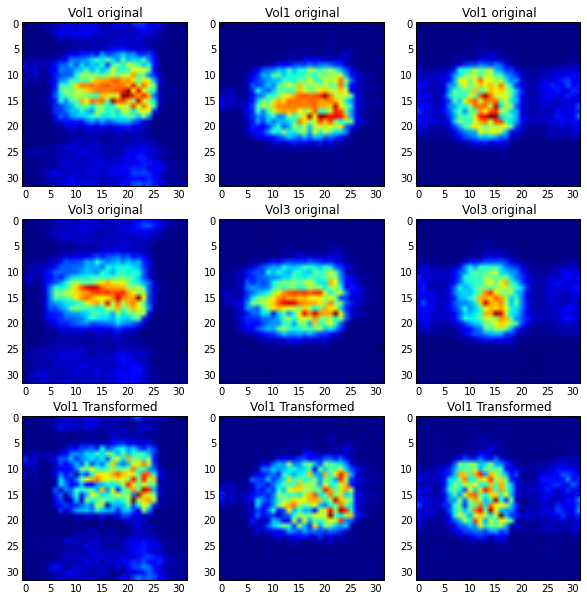

In [31]:
Trans = np.array([-1.2,0,0])
R = rotation_matrix_zyx(0,-5,0)
#vol1_trans = translation(vol3,Trans)
vol1_trans = transform(vol3,R, Trans)
fig, ax = plt.subplots(3,3)
fig.set_figwidth(10)
fig.set_figheight(10)
[ax[0][i].imshow(vol1.max(axis=i), cmap='jet') for i in xrange(3)]
[ax[0][i].set_title('Vol1 original') for i in xrange(3)]
[ax[1][i].imshow(vol1_trans.max(axis=i),cmap='jet') for i in xrange(3)]
[ax[1][i].set_title('Vol3 original') for i in xrange(3)]
[ax[2][i].imshow((vol1-vol1_trans).max(axis=i),cmap='jet') for i in xrange(3)]
[ax[2][i].set_title('Vol1 Transformed') for i in xrange(3)]
plt.show()
plt.close(fig)

### Use Theano to do gradient descent

In [110]:
#Define Theano Variables
T_vol1 = T.tensor3('vol1')
T_vol2 = T.tensor3('vol2')
T_trans = T.vector('trans')
T_rot = T.matrix('rot')

# define intermediate functions for GD
transformed_vol2 = transform(T_vol2, T_rot, T_trans)
err = T.sum(T.sqr(T_vol1-transformed_vol2))
gd_R, gd_t = T.grad(err,[T_rot,T_trans])

# define theano function for computing gradient
gradient = theano.function(inputs = [T_vol1, T_vol2, T_rot, T_trans], outputs = [err,gd_R,gd_t])
# compute cost function to verify the gradient descent restult
cost_func = theano.function(inputs = [T_vol1, T_vol2, T_rot, T_trans], outputs = [err])

In [125]:
# Gradient Descent
t0 = time.time()
R = rotation_matrix_zyx(0,0,0)
R = R.astype('float32')
t = np.zeros([3]).astype('float32')
learning_rate = 0.2
errors = []
count = 0
while True:
    count += 1
    R_old = R.copy()
    t_old = t.copy()
    error,rgd,rgt = gradient(vol1,vol3,R,t)
    errors.append(error)

    R -= learning_rate * rgd
    t -= learning_rate * rgt
    if((abs(np.max(R_old-R)) < 1e-5) & (abs(np.max(t_old-t)) < 1e-5)):
        break
print 'Minimized error: ', error
print 'Rotation angles R:\n', R
print 'Translation vector t:\n', t
print time.time()-t0

Minimized error:  0.0022410812936
Rotation angles R:
[[  1.00051630e+00   4.77869669e-03  -8.81773084e-02]
 [ -6.38889894e-03   1.00296104e+00  -7.32772110e-04]
 [  9.47198123e-02   8.36033549e-04   9.96822000e-01]]
Translation vector t:
[ 0.16923247 -0.01978016 -1.24928176]
58.1700811386


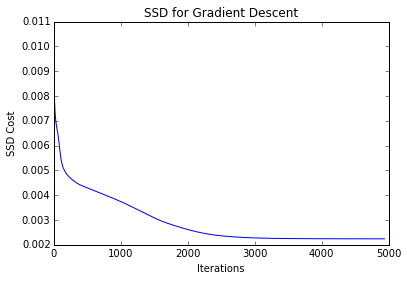

In [127]:
# plot the error
plt.plot(errors)
plt.title('SSD for Gradient Descent')
plt.xlabel('Iterations')
plt.ylabel('SSD Cost')
plt.show()

In [128]:
# compute cost function at the correct angle
R1 = rotation_matrix_zyx(0,-5,0)
R1 = R1.astype('float32')
t1 = np.array([0,0,-1.2]).astype('float32')
print cost_func(vol1,vol3,R1,t1)
print R1
print t1

[array(0.002470589025399574)]
[[ 0.99619472  0.         -0.08715574]
 [ 0.          1.          0.        ]
 [ 0.08715574  0.          0.99619472]]
[ 0.          0.         -1.20000005]


In [123]:
np.sin(to_radian(-5))

-0.087155742747658166